In [1]:
import gseapy as gp
import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
from scripts import aesthetics
from collections import defaultdict
import glob

aesthetics.activate_paper_rcParams()

In [2]:
# efficient fishers tests
import pyranges
import statsmodels.stats.multitest

# CWAS Gene Set Enrichment

In this notebook, we explore whether categories significantly enriched for SVs in cases vs. controls reflect any higher level biological process. One way to do this is with gene set enrichment.

# What is gene set enrichment anyway?

The idea of gene set enrichment is that in a list of genes (i.e. upregulated genes, or genes targeted by a "category"), if it were random, would have a certain degree of overlap with a gene set by pure chance. The idea of gene set enrichment is that we determine overlap with a gene set, and compare this to the background.

This is a bit weirder with these data, since we have actual _SV counts_. The underlying test for gene set enrichment is a fisher's exact test, which does work with counts, but it assumes independence between individual counts. Furthermore, the vast majority of gene set enrichment tools do not allow multiple counts of the same gene.

This means that we need to do this somewhat manually.

## How do we calculate things?

"Binary" gene set enrichment (e.g. an input list of unique genes, like differentially expressed genes, compared against gene sets of unique genes) is fundamentally based on overlap. The fisher's exact test examines associations between the two categorical variables--`in gene set` and `in input gene list`. This is based on the following contingency table:

```
in input and gene list | in input and not gene list
in gene list and not input | not in input and not in gene list
```

The bottom row is particularly crucial, because it forms the _background reference_. The GO website makes a big deal about this because it is by far the most specious part of this test. The reference should span _all possible genes that could be included_, and no more. Including genes that cannot possibly be in your input list artifically inflates effect sizes. It's the reason, for example, that it's incorrect to choose all genes in the reference genome when you pass in a DE gene list that excluded certain genes. Doing this will give you a "pre-enrichment" that has to do with your selection process and has nothing to do with your input gene list.

## What does this look like in our case?

Part of the issue with determining a reference is that there are _many_ valid references, each of which "controls" for some process. You might, for example, restrict an analysis to "highly expressed genes", which could control for the effect of gene expression.

Fundamentally, we have two "layers" of data here:

1. The genes in the gene set, category, and outside reference.
2. The SVs within these genes, category, and outside reference.

You can create several valid contingencies that each answer a separate question using these data. We'll discuss all the ones we'll run through.

## What is _not_ valid

It's worth discussing what is and what is not valid. For the fisher's exact test to be valid, the entry in every cell must be on the same scale. Consider the following example:

```
20 | 50
100 | 100

vs. 

20 | 50
200 | 200
```

These contingency tables yield the same odds-ratio, but the second has a dramatically lower p-value. The fisher's exact test is based on counts, so each entry in the cell is a sample size. This means that counts _cannot be normalized_, and they must be on the same scale.

In a previous version of this analysis, I used the following table:

```
counts of SVs in cat and gs | counts of SVs in cat and not gs
# of genes in gs and not cat | # of genes not in cat and not in gs
```

I did this because it was far easier to calculate the number of genes in a gene set and reference and not to worry about SVs. But this is incorrect--our estimation of the p-value will be quite biased, even if the SV counts exactly mirror gene counts.

## Valid tests we'll explore

### Pre-enrichment of categories 

We'll explore the following three contingency matrices:
 
```
number of genes in cat and gs | number of genes in cat and not gs
number of genes in gs and not cat | number of genes not in cat and not in gs
```

This effectively examines the "pre-enrichment" of categories for gene sets and ignores the role of SVs. We've already examined this in `pgsvs-extract-category-genes`.

### Dosage-ignoring gene effects

```
number of genes affected by SVs in cat and gs | number of genes affected by SVs in cat and not gs
number of genes in gs and not cat | number of genes not in cat and not in gs
```

This effectively subsets the above results to only those that are actually affected by SVs. I'm not sure if the bottom results should include "affected by SVs", but I don't think so. The "reference" set is all genes that _could_ be affected by SVs, which is all of them. This process ignores dosage beyond the first sample.

### Full count approach

```
count of genes affected by SVs in cat and gs | count of genes affected by SVs in cat and not gs
count of genes affected by SVs in gs and not cat | count of genes affected by SVs not in cat and not gs
```

This is the "broadest" version of this question. It asks whether our observed SV counts in a category reflect enrichment of that gene set.

With that said, let's implement all of these.

## Something I thought would work but doesnt

Initially, I thought you could separate out the category "pre-enrichment" from the SV enrichment, but I don't think that you can. You can do the category pre-enrichment, but there's no configuration of a contingency table that fully restricts both SV counts to the category and the reference to the category... 

Effectively, you can't make that last element `X not in cat and not gs`, because you've restricted everything to the category and gs. Doesn't work.

You can restrict to the category and check to see if `gs` elements have a higher burden than `non-gs` elements, I suppose? But that's just a numbers comparison.

# Load in the data

We load in the SVs and dosages, which we'll need.

## Read in SVs, metadata, dosages, and reference genes

In [3]:
# define SVs and dosages for discovery and validation
sv_path = "gs://vanallen-pedsv-analysis/beds/archive/v2.5.2/PedSV.v2.5.2.full_cohort.analysis_samples.sites.bed.gz"
dosages_path = "gs://vanallen-pedsv-analysis/beds/archive/v2.5.2/PedSV.v2.5.2.full_cohort.analysis_samples.allele_dosages.bed.gz"

# define metadata
metadata_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.2.cohort_metadata.w_control_assignments.tsv.gz"
samples_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.2.final_analysis_cohort.samples.list"

gene_ref_path = 'data/CWAS data for Jett/gencode_hg38_protein_coding_genes_for_annotation_7_31_23 (1).txt'

In [4]:
gene_ref = pd.read_csv(gene_ref_path)
gene_ref = gene_ref[~gene_ref['value'].str.startswith('ENSG00')]
gene_ref = sorted(set(gene_ref['value'].tolist()))
len(gene_ref)

19201

Load metadata and SVs

In [5]:
metadata = pd.read_csv(
    metadata_path,
    sep="\t",
)

# add a sex label to metadata
metadata["sex"] = (metadata["chrX_CopyNumber"].round() < 2).astype(int)

###############
### Samples ###
###############
samples = defaultdict(dict)

total_samples = []
for disease in ['neuroblastoma', 'ewing']:
    for cohort in ['case', 'control']:
        disease_cohort_samples = metadata[
                                    (metadata[f"{disease}_{cohort}"] == True)
                                    ]["entity:sample_id"].tolist()
        
        samples[disease][cohort] = disease_cohort_samples
        total_samples += disease_cohort_samples
        
        print(disease, cohort, len(disease_cohort_samples))

total_samples = sorted(set(total_samples))

neuroblastoma case 688
neuroblastoma control 4831
ewing case 775
ewing control 4574


In [6]:
len(total_samples)

6434

Now we load the SVs.

In [28]:
###############
##### SVs #####
###############
svs = pd.read_csv(
    sv_path,
    sep="\t",
    usecols=range(49)
)

###############
### Dosages ###
###############= 

# we only need the dosages of our samples in question
dosage_head = pd.read_csv(
    dosages_path,
    sep="\t",
    index_col = False,
    nrows = 1
)

cols = [3] + [i for i, c in enumerate(dosage_head.columns) if c in total_samples] 

dosages = pd.read_csv(
    dosages_path,
    sep="\t",
    index_col = False,
    usecols = cols
)

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (10,34,35,37,39,41,45,46,47,48) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [29]:
dosages = dosages.set_index('ID')

## Read in category genes

__Note:__ These aren't actually used (the category subsetting doesn't work), so we skip these steps.

In [9]:
category_gene_matrix = pd.read_csv('data/cwas-results/category-gene-matrix.csv').set_index('category')

In [10]:
category_gene_matrix.head(2)

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
category,,,,,,,,,,,,,,,,,,,,,
DEL.SINGLETON.ANY.unconstrained.expressed_in_adrenal_gland.protein_coding,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
DEL.SINGLETON.ANY.unconstrained.ANY.protein_coding,1,0,0,0,1,1,0,0,1,0,...,1,1,1,0,0,0,0,1,0,0


In [11]:
gene_ref = list(category_gene_matrix.columns)

## Read in the category results

I'm going to concatenate all this data so that I'm only dealing with a few files.

In [12]:
###########
### SVs ###
###########
category_svs = []
for file in glob.glob('data/CWAS data for Jett/List of variants by category/*.txt'):
    disease = file.split('/')[-1].split('_')[0]

    if disease == 'osteosarcoma':
        continue
    
    sv_category = 'noncoding' if 'noncoding' in file else 'coding'
    af_category = 'singleton' if 'SINGLETON' in file else 'rare'
    
    cat_svs = pd.read_csv(file, sep='\t').rename(columns = {'emd': 'end'})
    cat_svs[['disease', 'sv_category', 'af_category']] = [disease, sv_category, af_category]
    category_svs.append(cat_svs)
    
category_svs = pd.concat(category_svs)
category_svs.head(2)

,SV,chrom,start,end,category,disease,sv_category,af_category
0,PedSV.2.5.2_DUP_chr1_455,chr1,6720524,6722070,DUP.RARE.PREDICTED_NONCODING_BREAKPOINT.ewing_...,ewing,noncoding,rare
1,PedSV.2.5.2_DUP_chr1_898,chr1,23649481,23651544,DUP.RARE.PREDICTED_NONCODING_BREAKPOINT.ewing_...,ewing,noncoding,rare


In [13]:
#########################
### FRAMEWORK RESULTS ###
#########################
framework_results = []
for file in glob.glob('data/CWAS data for Jett/CWAS sum stats/*.txt'):
    if '12_26_23' not in file:
        continue

    disease = file.split('/')[-1].split('_')[0]

    if disease == 'osteosarcoma':
        continue
    
    sv_category = 'noncoding' if 'noncoding' in file else 'coding'
    af_category = 'singleton' if 'SINGLETON' in file else 'rare'
    
    data = pd.read_csv(file, sep='\t')
    data[['disease', 'sv_category', 'af_category']] = [disease, sv_category, af_category]
    framework_results.append(data)
        
framework_results = pd.concat(framework_results)

In [14]:
framework_results.head(2)

,point_estimate,std_error,z_score,p_value,SV_counts_cases,SV_counts_cases_max,number_of_cases_with_zero_SVs,total_cases,SV_counts_controls,SV_counts_controls_max,...,category_name,sv_type,frequency,mean_SVs_per_case,mean_SVs_per_control,mean_SVs_total,negative_log10_p_value,disease,sv_category,af_category
0,0.175033,0.771178,0.226968,0.820448,2,1,644,646,12,1,...,DEL.SINGLETON.ANY.missense_constrained.ANY.sig...,DEL,SINGLETON,0.003096,0.002554,0.002619,0.085949,neuroblastoma,coding,singleton
1,0.245302,0.150614,1.628679,0.103381,53,1,593,646,309,2,...,DEL.SINGLETON.ANY.unconstrained.expressed_in_a...,DEL,SINGLETON,0.082043,0.065759,0.067727,0.985559,neuroblastoma,coding,singleton


In [15]:
framework_schema = defaultdict(dict)
for file in glob.glob('data/CWAS data for Jett/CWAS frameworks/*.txt'):
    if 'osteosarcoma' in file:
        continue

    disease = 'neuroblastoma' if 'neuroblastoma' in file else 'ewing'
    sv_category = 'noncoding' if 'noncoding' in file else 'coding'
    
    data = pd.read_csv(file, sep = '\t')
    framework_schema[disease][sv_category] = data

In [16]:
framework_schema['ewing']['noncoding']

,sv_type,frequency,functional_intersection,functional_category,genic_relationship,constraint,expression,gene_group
0,DUP,RARE,PREDICTED_NONCODING_BREAKPOINT,ewing_and_osteosarcoma_atac_peaks,PREDICTED_INTERGENIC,lof_constrained,expressed_in_muscle_skeletal,protein_coding
1,DEL,SINGLETON,PREDICTED_NONCODING_SPAN,ewing_chromHMM15_EnhBiv,PREDICTED_INTRONIC,ANY,ANY,cosmic_and_germline_CPGs
2,CPX_or_INV,NaN,ANY,ewing_H3K27Ac_peak,PREDICTED_PROMOTER,NaN,NaN,NaN
3,INS_ALL,NaN,NaN,ewing_ABC_MAX_enhancer,PREDICTED_UTR,NaN,NaN,NaN
4,ANY,NaN,NaN,ewing_chromHMM15_Enh,ANY,NaN,NaN,NaN
5,NaN,NaN,NaN,ewing_chromHMM15_TssAFlnk,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,ewing_and_osteosarcoma_atac_peaks_conserved,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,ewing_and_osteosarcoma_tad_boundary,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,ewing_chromHMM15_EnhBiv_conserved,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,ewing_chromHMM15_TssAFlnk_conserved,NaN,NaN,NaN,NaN


# Defining our reference gene counts

Here, we define the various "references" for our three contingency tables:

* Dosage-ignoring gene effects: reference is simply the total gene list
* Full count: reference is the _gene counts of all SVs_

The last reference is what we need to define. The issue is that this depends on our specific question. Non-coding SV analyses shouldn't include coding SVs, since we're not interested in coding effects vs. non-coding effects. We're interested in subsetting to coding effects. 

In that case, we also need to define variables that change how we calculate this reference.

`coding vs. non-coding`  
`cases vs. controls vs. control_subtraction`  

I'm simply going to drop all SVs that have multiple gene effects. There aren't that many of them and dealing with an extra layer is super annoying.

## Adding an annotation for coding/non-coding/multi effects

Needed for filtering out multi SVs

In [31]:
# an svs is True for "multiple-genes-coding" if it affects more than one gene across all coding genic relationships.
# The same is true for multiple-genes-noncoding.
coding_cols = ['PREDICTED_LOF', 'PREDICTED_PARTIAL_EXON_DUP', 'PREDICTED_INTRAGENIC_EXON_DUP', 'PREDICTED_COPY_GAIN']
noncoding_cols = ['PREDICTED_NEAREST_TSS', 'PREDICTED_INTRONIC', 'PREDICTED_PROMOTER', 'PREDICTED_UTR']

for label, cols in zip(['coding', 'noncoding', 'both'], [coding_cols, noncoding_cols, coding_cols + noncoding_cols]):
    
    # we define all the genes that are "affected" by an SV. We
    # do this by looking at successive genic relationships
    affected_genes = np.array(svs[cols[0]].fillna('').str.split(','))
    for c in cols[1:]:
        affected_genes += np.array(svs[c].fillna('').str.split(','))
    
    # remove blanks
    affected_genes = [[g for g in g_list if g != ''] for g_list in affected_genes]
    affected_genes_col = [','.join(g_list) for g_list in affected_genes]
    
    # extract out how many unique genes are affected by each SV
    num_unique_affected_genes = [len(set(g_list)) for g_list in affected_genes]
    multiple_genes = np.array(num_unique_affected_genes) > 1
    
    # add a column to our SVs
    svs[f'num_genes_{label}'] = num_unique_affected_genes
    svs[f'genes_{label}'] = affected_genes_col

In [32]:
multigene_svs = svs.query('num_genes_both > 1')

svs.shape, multigene_svs.shape

((228943, 55), (2155, 55))

We drop these SVs.

In [33]:
svs = svs.query('num_genes_both <= 1').copy()
category_svs = category_svs[~(category_svs['SV'].isin(multigene_svs['name'].tolist()))].copy()

## Create references

In [ ]:
reference_svs = pd.DataFrame(columns = gene_ref, index = range(12))
row_idx = 0
row_names = []

# identify rare SVs first
rare_svs = svs[svs['AF'] < 0.01].copy().set_index('name')

# check that all our category SVs are here
assert len(set(category_svs['SV']) - set(rare_svs.index)) == 0

for disease in ['neuroblastoma', 'ewing']:
    
    sub_reference = rare_svs.copy()
    disease_samples = samples[disease]
    
    # identify SVs that affect genes in coding or non-coding fashion
    for sv_category in ['coding', 'noncoding']:
        sub_reference = rare_svs[rare_svs[f'num_genes_{sv_category}'] > 0]
            
        gene_counts = {}
        for cohort in ['case', 'control']:

            # subset to SVs with at least one non-zero sample
            cohort_samples = disease_samples[cohort]
            sub_dosages = dosages.loc[sub_reference.index, cohort_samples]

            # drop SVs with bad genotyping and fill in na's as 0 (ignored)
            kept_samples = np.where(pd.isnull(sub_dosages).sum(axis = 0) / len(sub_dosages) < 0.05)[0]
            sub_dosages = sub_dosages.iloc[:, kept_samples].fillna(0).astype(int)

            # drop SVs with no counts
            sub_dosages = sub_dosages[sub_dosages.sum(axis = 1) > 0]

            # finally, we create the gene list with counts
            sv_counts = sub_dosages.sum(axis = 1)
            sv_genes = sub_reference.loc[sv_counts.index, f'genes_{sv_category}']

            gene_list = []
            for i in range(len(sv_counts)):
                gene_list += sv_genes[i].split(',') * sv_counts[i]

            # count the genes
            cohort_gene_counts = pd.DataFrame(np.unique(gene_list, return_counts = True), 
                                              index = ['gene', 'count']).T
            
            # remove genes not in our reference (shouldn't happen, but just in case)
            cohort_gene_counts = cohort_gene_counts[cohort_gene_counts['gene'].isin(gene_ref)]
            
            # store
            gene_counts[cohort] = cohort_gene_counts
            
        control_genes = gene_counts['control']['gene'].tolist()
        case_unique = gene_counts['case'][lambda row: ~row['gene'].isin(control_genes)].copy()
        gene_counts['case_unique'] = case_unique
        
        # add these all to the reference list
        for cohort in ['case', 'control', 'case_unique']:
            cohort_data = gene_counts[cohort]
            reference_svs.loc[row_idx, cohort_data['gene'].tolist()] = cohort_data['count'].values
            row_idx += 1
            
            row_names.append([disease, sv_category, cohort])
        print(disease, sv_category)
        
reference_svs = reference_svs.fillna(0).astype(int)

row_names = pd.DataFrame(row_names, columns = ['disease', 'sv_category', 'cohort'])
reference_svs['disease'] = row_names['disease']
reference_svs['sv_category'] = row_names['sv_category']
reference_svs['cohort'] = row_names['cohort']

reference_svs = reference_svs.set_index(['disease', 'sv_category', 'cohort']).copy()

In [37]:
reference_svs

A1BG  A1CF  A2M  A2ML1  A3GALT2  \
disease       sv_category cohort                                         
neuroblastoma coding      case            0     0    0      0       10   
                          control         0     0    0      3       36   
                          case_unique     0     0    0      0        0   
              noncoding   case            0     9    2     15        8   
                          control         2    40   13    237       73   
                          case_unique     0     0    0      0        0   
ewing         coding      case            0     0    0      0        7   
                          control         0     0    0      1       50   
                          case_unique     0     0    0      0        0   
              noncoding   case            0     0    3     23       11   
                          control         2    28   13    211       72   
                          case_unique     0     0    0      0        0   

                                       A4GALT  A4GNT  AAAS  AACS  AADAC  ...  \
disease       sv_category cohort                                         ...   
neuroblastoma coding      case              0      0     0     0     19  ...   
                          control           0      1     0     0     74  ...   
                          case_unique       0      0     0     0      0  ...   
              noncoding   case              5      0     0     2      4  ...   
                          control          49      3     1    12      7  ...   
                          case_unique       0      0     0     0      0  ...   
ewing         coding      case              0      0     0     0     12  ...   
                          control           0      1     0     0     73  ...   
                          case_unique       0      0     0     0      0  ...   
              noncoding   case              7      1     0     2      1  ...   
                          control          40      3     1    10      5  ...   
                          case_unique       0      0     0     0      0  ...   

                                       ZWILCH  ZWINT  ZXDA  ZXDB  ZXDC  \
disease       sv_category cohort                                         
neuroblastoma coding      case              0      1     0     0     0   
                          control           0      3     0     0     0   
                          case_unique       0      0     0     0     0   
              noncoding   case              3     94     5     2     1   
                          control           9    715    41     5     2   
                          case_unique       0      0     0     0     0   
ewing         coding      case              0      2     0     0     0   
                          control           0      3     0     0     0   
                          case_unique       0      0     0     0     0   
              noncoding   case              1     86     9     1     0   
                          control           7    510    38     6     2   
                          case_unique       0      0     0     0     0   

                                       ZYG11A  ZYG11B  ZYX  ZZEF1  ZZZ3  
disease       sv_category cohort                                         
neuroblastoma coding      case              0       0    0      0     0  
                          control           0       0    0      0     0  
                          case_unique       0       0    0      0     0  
              noncoding   case              2       0    0      9     2  
                          control          24      16    1     84     4  
                          case_unique       0       0    0      0     0  
ewing         coding      case              1       0    0      0     0  
                          control           0       0    0      0     0  
                          case_unique       1       0    0      0     0  
              noncoding   case

## Shrink down our data

We subset some of our data to prevent working with massive matrices.

In [38]:
# shrink down our categories to only those that are significant
framework_results = framework_results.query('negative_log10_p_value > 3.0').reset_index(drop = True)

# subset our SVs to these categories. Have to be careful about disease, since category names can repeat.
included_disease_categories = (framework_results['disease'] + '-' + framework_results['category_name']).tolist()

# subset down category svs to these categories
category_svs = category_svs[(category_svs['disease'] + '-' + category_svs['category']).isin(included_disease_categories)].reset_index(drop = True)

# drop SVs down to these SVs
svs = svs[svs['name'].isin(set(category_svs['SV']))]

# shrink dosages down to our nbl samples and these SVs
dosages = dosages.loc[svs['name'].tolist(), total_samples]

# shrink down category lookups
category_gene_matrix = category_gene_matrix.loc[sorted(set(framework_results['category_name']))]

In [39]:
category_gene_matrix.shape, dosages.shape, svs.shape

((160, 19092), (18183, 6434), (18183, 55))

# A coding example

Let's extract out all the data that we need to examine the highest result for a single hallmark gene set. We're using a coding category

We'll generate data for our two contingency tables.

In [54]:
test_category = 'ANY.SINGLETON.ANY.ANY.ANY.protein_coding'
category_components = test_category.split(".")
genic_rel = category_components[2]
test_category, genic_rel

('ANY.SINGLETON.ANY.ANY.ANY.protein_coding', 'ANY')

In [55]:
framework_schema['neuroblastoma']['coding'].head(5)

,sv_type,frequency,genic_relationship,constraint,expression,gene_group
0,DUP,RARE,PREDICTED_COPY_GAIN,lof_constrained,expressed_in_adrenal_gland,protein_coding
1,DEL,SINGLETON,PREDICTED_INTRAGENIC_EXON_DUP,missense_constrained,ANY,cosmic_cancer_genes
2,CPX_or_INV,NaN,PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP,unconstrained,NaN,germline_CPGs
3,INS_ALL,NaN,ANY,ANY,NaN,base_excision_repair_genes
4,ANY,NaN,NaN,NaN,NaN,chromatin_organization_genes


We identify the SVs that are part of that category.

In [56]:
svs_in_category = category_svs[(category_svs["category"] == test_category) &
                               (category_svs['disease'] == 'neuroblastoma')]

# subset the actual SV matrix
svs_in_category = svs[svs["name"].isin(svs_in_category["SV"].tolist())]

svs_in_category.head(2)

,#chrom,start,end,name,svtype,AC,AF,ALGORITHMS,AN,BOTHSIDES_SUPPORT,...,PREDICTED_PARTIAL_EXON_DUP,PREDICTED_PROMOTER,PREDICTED_TSS_DUP,PREDICTED_UTR,num_genes_coding,genes_coding,num_genes_noncoding,genes_noncoding,num_genes_both,genes_both
64,chr1,923800,943501,PedSV.2.5.2_DEL_chr1_80,DEL,1,0.000077,depth,13038,False,...,NaN,NaN,NaN,NaN,1,SAMD11,0,,1,SAMD11
152,chr1,1240217,1243609,PedSV.2.5.2_DEL_chr1_210,DEL,1,0.000074,manta,13462,True,...,NaN,NaN,NaN,NaN,1,C1QTNF12,0,,1,C1QTNF12


Next, we determine the genes in question. We reference the column where the genes can be found, `genic_relationship`. `ANY` needs to be converted to all of them.

In [62]:
genic_rel = ['PREDICTED_LOF', 'PREDICTED_PARTIAL_EXON_DUP', 'PREDICTED_INTRAGENIC_EXON_DUP', 'PREDICTED_COPY_GAIN']

In [77]:
svs_in_category[genic_rel].head()

,PREDICTED_LOF,PREDICTED_PARTIAL_EXON_DUP,PREDICTED_INTRAGENIC_EXON_DUP,PREDICTED_COPY_GAIN
64,SAMD11,NaN,NaN,NaN
152,C1QTNF12,NaN,NaN,NaN
173,CPTP,NaN,NaN,NaN
308,CFAP74,NaN,NaN,NaN
322,CFAP74,NaN,NaN,NaN


In [64]:
nbl_sv_dosages = (
    dosages
    .loc[svs_in_category["name"].tolist(), samples['neuroblastoma']['case'] + samples['neuroblastoma']['control']]
)
nbl_sv_dosages.head(2)

,PT_00QYKRAX,PT_00Y8C0XA,PT_025YMME2,PT_02AE4RSP,PT_02SNWVRF,PT_06Z51EN5,PT_0CKD259J,PT_0GMP9VVY,PT_0MVMPZKX,PT_11XN6CG5,...,ssi_26401,ssi_26409,ssi_26411,ssi_26422,ssi_26442,ssi_26452,ssi_26453,ssi_26458,ssi_26459,ssi_26463
ID,,,,,,,,,,,,,,,,,,,,,
PedSV.2.5.2_DEL_chr1_80,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PedSV.2.5.2_DEL_chr1_210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
len(samples['neuroblastoma']['case'] + samples['neuroblastoma']['control'])

5519

In [66]:
nbl_sv_dosages.shape

(4013, 5519)

So we now have the dosages for both cases and controls. We analyze these two datasets separately, and will need to determine post-hoc if there is a unique enrichment in cases vs. control. Additionally, we need to drop samples that are poorly genotyped for these SVs. The strategy that Ryan and Riaz used is to drop samples with >5% `NaN` genotyping rate. We do that here.

In [67]:
kept = pd.isnull(nbl_sv_dosages).sum(axis = 0) / len(nbl_sv_dosages) < 0.05

nbl_kept_cases = list(set(samples['neuroblastoma']['case']) & set(kept[kept].index))
nbl_kept_controls = list(set(samples['neuroblastoma']['control']) & set(kept[kept].index))

In [68]:
nbl_sv_dosages = nbl_sv_dosages.loc[:, kept]

In [69]:
nbl_sv_dosages.shape

(4013, 5346)

So now we can generate our counts. Drop SVs with no counts.

In [96]:
nbl_sv_dosages = nbl_sv_dosages[nbl_sv_dosages.fillna(0).sum(axis = 1) > 0]
nbl_sv_dosages = nbl_sv_dosages.fillna(0).astype(int)

# further subset data to these svs
svs_in_category = svs_in_category[svs_in_category['name'].isin(nbl_sv_dosages.index)]

In [97]:
# get the SV counts of our cases and controls
sv_counts_cases = nbl_sv_dosages[nbl_kept_cases].sum(axis=1)
sv_counts_controls = nbl_sv_dosages[nbl_kept_controls].sum(axis=1)
sv_counts_cases.head()

ID
PedSV.2.5.2_DEL_chr1_210     0
PedSV.2.5.2_DEL_chr1_248     0
PedSV.2.5.2_DEL_chr1_404     0
PedSV.2.5.2_DEL_chr1_833     1
PedSV.2.5.2_DEL_chr1_1128    0
dtype: int64

Note that some SVs have 0 counts, presumably because those SVs are present in non-neuroblastoma samples (after checking, this is indeed true.)

Alright, we can move on and actually count things up. First, how many SVs are we actually dealing with here?

In [98]:
sv_counts_cases.sum(), sv_counts_controls.sum()

(436, 2576)

We can see that the cases have a higher proportion of counts relative to the proportion of samples, which is what we expect (this category is significant).

Let's see what happens when we convert to gene counts.

In [99]:
genes_in_svs = svs_in_category[['name'] + genic_rel].set_index('name')

In [117]:
gene_counts = {'case': [], 'control': []}
for cohort, sv_counts in zip(['case', 'control'], [sv_counts_cases, sv_counts_controls]):

    sample_genes_in_svs = genes_in_svs.copy()
    sample_genes_in_svs.loc[sv_counts.index, 'count'] = sv_counts.astype(int)

    # simple enough to go through
    cohort_gene_counts = []
    for index, row in sample_genes_in_svs.iterrows():
        for col in genic_rel:
            if not pd.isnull(row[col]):
                cohort_gene_counts += [row[col]] * row['count']

    cohort_gene_counts = pd.DataFrame(np.unique(cohort_gene_counts, return_counts = True), index = ['gene', 'count']).T    
    cohort_gene_counts = cohort_gene_counts[cohort_gene_counts['gene'].isin(gene_ref)]
    gene_counts[cohort] = cohort_gene_counts

# we generate case_unique here because it's easy
control_genes = set(gene_counts['control']['gene'])
gene_counts['case_unique'] = gene_counts['case'][lambda row: ~row['gene'].isin(control_genes)]

In [118]:
gene_counts['case'].shape, gene_counts['control'].shape, gene_counts['case_unique'].shape

((404, 2), (2115, 2), (288, 2))

Great. Now we can try merging this with a gene set to test significance. We'll try it with a small, well characterized gene set first.

In [119]:
hallmark = gp.get_library(name='MSigDB_Hallmark_2020')

In [153]:
adipogenesis = hallmark['Adipogenesis']
adipogenesis = [g for g in adipogenesis if g in gene_ref]
len(adipogenesis)

200

## Simple gene count overlap

Here, we ignore the gene counts and simply overlap with the _entire_ reference counts.

```
number of genes affected by SVs in cat and gs | number of genes affected by SVs in cat and not gs
number of genes in gs and not cat | number of genes not in cat and not in gs
```

In [157]:
for cohort in ['case', 'control', 'case_unique']:
    
    cohort_gene_counts = gene_counts[cohort]

    num_genes_in_cat_and_gs = (cohort_gene_counts[cohort_gene_counts['gene'].isin(adipogenesis)]['count'] > 0).sum()
    num_genes_in_cat_and_not_gs = (cohort_gene_counts[~cohort_gene_counts['gene'].isin(adipogenesis)]['count'] > 0).sum()

    num_genes_in_gs_and_not_cat = len(set(adipogenesis) - set(cohort_gene_counts['gene']))
    num_genes_not_in_gs_and_not_cat = len(set(gene_ref) - set(adipogenesis) - set(cohort_gene_counts['gene']))
    
    cont_table = np.array([[num_genes_in_cat_and_gs, num_genes_in_cat_and_not_gs],
                           [num_genes_in_gs_and_not_cat, num_genes_not_in_gs_and_not_cat]])
    print(scipy.stats.fisher_exact(cont_table))

(3.01237516283109, 0.0011798106895463004)
(0.8411813082535532, 0.5707060561953881)
(3.5240439227565314, 0.0009490552119818304)


So this is significant. But remember that this process ignores SV dosage beyond the first SV. Let's try the other way--using actual SV counts. This changes our reference.



In [241]:
for cohort in ['case', 'control', 'case_unique']:
    
    cohort_gene_counts = gene_counts[cohort]

    num_genes_in_cat_and_gs = cohort_gene_counts[cohort_gene_counts['gene'].isin(adipogenesis)]['count'].sum()
    num_genes_in_cat_and_not_gs = cohort_gene_counts[~cohort_gene_counts['gene'].isin(adipogenesis)]['count'].sum()

#     num_genes_in_gs_and_not_cat = len(set(adipogenesis) - set(cohort_gene_counts['gene']))
#     num_genes_not_in_gs_and_not_cat = len(set(gene_ref) - set(adipogenesis) - set(cohort_gene_counts['gene']))
    
#     cont_table = np.array([[num_genes_in_cat_and_gs, num_genes_in_cat_and_not_gs],
#                            [num_genes_in_gs_and_not_cat, num_genes_not_in_gs_and_not_cat]])
#     print(scipy.stats.fisher_exact(cont_table))
    raise

RuntimeError: No active exception to reraise

In [243]:
num_genes_in_cat_and_not_gs

425

In [244]:
num_genes_in_cat_and_gs / 438

0.02968036529680365

In [266]:
num_genes_in_cat_and_gs

13

In [260]:
a = np.array(range(19092))
indices = np.concatenate([np.random.choice(a.size, size=438, replace=True) for _ in range(100000)])
result = a[indices].reshape(100000, 438)

In [272]:
data = np.random.choice(a.size, size=(1000000, 438), replace=True)

In [276]:
((data < 200).sum(axis = 1) >= 13).mean()

0.000853

In [267]:
((result < 200).sum(axis = 1) > 13).mean()

0.0002

In [275]:
scipy.stats.binom_test(13, 438, 200/19092)

0.0008869380678337747

In [279]:
test = np.array([[13, 425], [200, 19092 - 200]])
scipy.stats.fisher_exact(test)

(2.889364705882353, 0.001086350876976585)

### Full count approach

```
count of genes affected by SVs in cat and gs | count of genes affected by SVs in cat and not gs
count of genes affected by SVs in gs and not cat | count of genes affected by SVs not in cat and not gs
```



In [158]:
eligible_genes = category_gene_matrix.loc[test_category]
genes_in_cat = eligible_genes[eligible_genes == 1].index
genes_not_in_cat = eligible_genes[eligible_genes == 0].index

In [ ]:
for cohort in ['case', 'control']:
    
    cohort_gene_counts = gene_counts[cohort]

    count_genes_in_cat_and_gs = (cohort_gene_counts[cohort_gene_counts['gene'].isin(g2m_checkpoint)]['count']).sum()
    count_genes_in_cat_and_not_gs = (cohort_gene_counts[~cohort_gene_counts['gene'].isin(g2m_checkpoint)]['count']).sum()

    # to get the 
    count_genes_in_gs_and_not_cat = len(set(g2m_checkpoint) - set(cohort_gene_counts['gene']))
    count_genes_not_in_gs_and_not_cat = len(set(gene_ref) - set(g2m_checkpoint) - set(cohort_gene_counts['gene']))
    
    cont_table = np.array([[num_genes_in_cat_and_gs, num_genes_in_cat_and_not_gs],
                           [num_genes_in_gs_and_not_cat, num_genes_not_in_gs_and_not_cat]])
    print(scipy.stats.fisher_exact(cont_table))

In [155]:
test = np.array([[10, 200], [0, 0]])

In [156]:
scipy.stats.fisher_exact(test)

(nan, 1.0)

In [47]:
category_genes = category_gene_matrix.loc[test_category]
category_genes = list(category_genes[category_genes == 1].index)
print(len(category_genes))

5936


So only ~6k genes. This is now our reference gene set.

In [48]:
g2m_checkpoint_subset = set(g2m_checkpoint) & set(category_genes)
len(g2m_checkpoint_subset)

73

We have to drop genes that are in the category but are not in our category reference (which can happen for a variety of reasons, but generally shouldn't be too severe).

In [49]:
for cohort in ['cases', 'controls']:
    
    cohort_gene_counts = gene_counts[cohort]
    cohort_gene_counts = cohort_gene_counts[cohort_gene_counts['gene'].isin(category_genes)]

    genes_in_category_and_gs = cohort_gene_counts[cohort_gene_counts['gene'].isin(g2m_checkpoint_subset)]['count'].sum()
    genes_in_category_and_not_gs = cohort_gene_counts[~cohort_gene_counts['gene'].isin(g2m_checkpoint_subset)]['count'].sum()

    genes_not_in_category_and_in_gs = len(set(g2m_checkpoint_subset) - set(cohort_gene_counts['gene']))
    genes_not_in_category_and_not_gs = len(category_genes) - genes_not_in_category_and_in_gs - genes_in_category_and_not_gs + genes_in_category_and_gs
    
    cont_table = np.array([[genes_in_category_and_gs, genes_in_category_and_not_gs], 
                           [genes_not_in_category_and_in_gs, genes_not_in_category_and_not_gs]])

    print(scipy.stats.fisher_exact(cont_table))

(1.9309269162210339, 0.10667846501827494)
(1.1210609839038768, 0.7007831753369294)


In [51]:
len(g2m_checkpoint) + len(category_genes)

6135

In [52]:
cont_table.sum()

5982

So we see even after subsetting, the category retains some signal for this gene set.

As another crazy idea (which I think is actually the correct way to use counts), what if we use counts as the reference?

Note that this requires us to use _all other SVs_

In [ ]:
for cohort in ['cases', 'controls']:
    
    cohort_gene_counts = gene_counts[cohort]

    genes_in_category_and_gs = cohort_gene_counts[cohort_gene_counts['gene'].isin(g2m_checkpoint)]['count'].sum()
    genes_in_category_and_not_gs = cohort_gene_counts[~cohort_gene_counts['gene'].isin(g2m_checkpoint)]['count'].sum()

    genes_not_in_category_and_in_gs = len(set(g2m_checkpoint_subset) - set(cohort_gene_counts['gene']))
    genes_not_in_category_and_not_gs = len(category_genes) - genes_not_in_category_and_in_gs - genes_in_category_and_not_gs + genes_in_category_and_gs
    
    cont_table = np.array([[genes_in_category_and_gs, genes_in_category_and_not_gs], 
                           [genes_not_in_category_and_in_gs, genes_not_in_category_and_not_gs]])

    print(scipy.stats.fisher_exact(cont_table))


Now we generalize across all gene sets.

In [44]:
hallmark_results = []
for gs, genes in hallmark.items():
    
    genes = [g for g in genes if g in gene_ref]
    
    # store the expected frequency
    expected = f'{len(genes)}/{len(gene_ref)}'
    row = [gs, expected]
    
    for cohort in ['cases', 'controls']:
        
        cohort_gene_counts = gene_counts[cohort]
        
        top_left = cohort_gene_counts[cohort_gene_counts['gene'].isin(genes)]['count'].sum()
        top_right = cohort_gene_counts[~cohort_gene_counts['gene'].isin(genes)]['count'].sum()

        bottom_left = len(set(genes) - set(cohort_gene_counts['gene']))
        botttom_right = len(gene_ref) - bottom_left

        cont_table = np.array([[top_left, top_right], 
                               [bottom_left, botttom_right]])
        res, p = scipy.stats.fisher_exact(cont_table)

        # provide the expected and the data frequencies
        data = f'{top_left}/{top_left + top_right}'
        row += [res, p, data]
        
    hallmark_results.append(row)
    
col_names = ['gene_set', 'expected', 'case_stat', 'case_p', 'case_data', 'control_stat', 'control_p', 'control_data']
hallmark_results = pd.DataFrame(hallmark_results, columns = col_names)

In [45]:
hallmark_results.query('case_p < 0.05')

,gene_set,expected,case_stat,case_p,case_data,control_stat,control_p,control_data
3,Mitotic Spindle,199/19092,3.086910,0.002410,10/334,1.557596,5.349336e-02,25/1760
12,Estrogen Response Early,197/19092,2.454377,0.020954,8/334,2.310539,3.931636e-05,36/1760
21,Hedgehog Signaling,36/19092,5.234551,0.023665,3/334,1.696937,2.368055e-01,5/1760
25,mTORC1 Signaling,199/19092,2.740379,0.007931,9/334,0.806268,5.246697e-01,14/1760
38,UV Response Dn,143/19092,3.445944,0.003356,8/334,3.673635,7.584319e-10,38/1760


In [46]:
hallmark_results.query('gene_set == "G2-M Checkpoint"')

,gene_set,expected,case_stat,case_p,case_data,control_stat,control_p,control_data
8,G2-M Checkpoint,199/19092,2.107225,0.087967,7/334,1.452535,0.098259,24/1760


# Do some deeper filtering

After the first round of these results, Ryan made the excellent point that some of these SVs can be quite large and may include many many genes. He and Riaz offered some thoughts for how we might narrow some of these results to give us a little bit more focus. Namely:

1. Subset the SVs examined to those that _only affect an individual gene_. We'll call this approach `single-gene`. For SVs that affeect more than one gene across multiple genic relationships, we'll remove all SVs that don't affect one unique gene. This is quite radical.
2. Only include genes that have _no affected counts in controls_. This effectively "subtracts" out the signal from controls, which should subset our results significantly. We'll call this approach `control-subtraction`.
3. Think carefully about deletions vs. duplications (i.e. think about the effect of individual variants). This is quite hard to think about, but we can keep track of it in our dataframe and then examine post-hoc.

## How to identify "single gene SVs"

This definition is very fraught--if we are only examining a single genic relationship, we WILL count SVs that affect other genes in other genic relationships. So to assess all categories equally, we need to do this filtering _up front_. We're just going to be as conservative as possible.

In [47]:
# briefly examine the SVs that have multiple genic relationships filled 
multiple = (~pd.isnull(svs['PREDICTED_LOF'])).astype(int) + (~pd.isnull(svs['PREDICTED_PARTIAL_EXON_DUP'])).astype(int) + (~pd.isnull(svs['PREDICTED_INTRAGENIC_EXON_DUP'])).astype(int) + (~pd.isnull(svs['PREDICTED_COPY_GAIN'])).astype(int)
multiple_gene_svs = svs[multiple > 1][['PREDICTED_LOF', 'PREDICTED_PARTIAL_EXON_DUP', 'PREDICTED_INTRAGENIC_EXON_DUP', 'PREDICTED_COPY_GAIN']]
print(multiple_gene_svs.shape[0], 'out of', svs[multiple > 0].shape[0], 'coding SVs have multiple genic relationships')
multiple_gene_svs.head(6)

49 out of 4902 coding SVs have multiple genic relationships


,PREDICTED_LOF,PREDICTED_PARTIAL_EXON_DUP,PREDICTED_INTRAGENIC_EXON_DUP,PREDICTED_COPY_GAIN
1222,"CTNNBIP1,NMNAT1",NaN,NaN,LZIC
1698,CELA2A,NaN,CELA2B,NaN
5875,CACHD1,NaN,CACHD1,NaN
11143,FCRL6,NaN,FCRL6,NaN
12059,NaN,NaN,RABGAP1L,GPR52
15644,PYCR2,PYCR2,NaN,NaN


We see that this is not all that common - only 71 coding SVs affect multiple genes. But they could be contributing a large number of counts. Let's add a row to our SVs

761 out of 4902 (15.5%) coding SVs that affect at least one gene affect more than one gene
131 out of 14457 (0.9%) non-coding SVs that affect at least one gene affect more than one gene
980 out of 19122 (5.1%) both SVs that affect at least one gene affect more than one gene


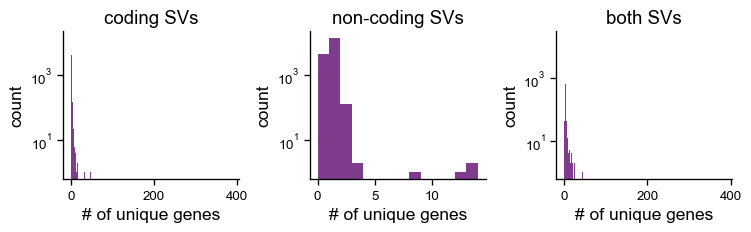

In [48]:
# an svs is True for "multiple-genes-coding" if it affects more than one gene across all coding genic relationships. The same is true for multiple-genes-noncoding.
coding_cols = ['PREDICTED_LOF', 'PREDICTED_PARTIAL_EXON_DUP', 'PREDICTED_INTRAGENIC_EXON_DUP', 'PREDICTED_COPY_GAIN']
noncoding_cols = ['PREDICTED_NEAREST_TSS', 'PREDICTED_INTRONIC', 'PREDICTED_PROMOTER', 'PREDICTED_UTR']

fig, axes = plt.subplots(1, 3, figsize = (9, 2), gridspec_kw = {'wspace': 0.4})
for i, (label, cols) in enumerate(zip(['coding', 'non-coding', 'both'], [coding_cols, noncoding_cols, coding_cols + noncoding_cols])):
    
    # we define all the genes that are "affected" by an SV. We
    # do this by looking at successive genic relationships
    affected_genes = np.array(svs[cols[0]].fillna('').str.split(','))
    for c in cols[1:]:
        affected_genes += np.array(svs[c].fillna('').str.split(','))
        
    # extract out how many unique genes are affected by each SV
    num_unique_affected_genes = [len(set([g for g in g_list if g != ''])) for g_list in affected_genes]
    multiple_genes = np.array(num_unique_affected_genes) > 1
    at_least_one_gene = np.array(num_unique_affected_genes) > 0
    
    # create a plot
    ax = axes[i]
    ax.hist(num_unique_affected_genes, bins = np.arange(max(num_unique_affected_genes) + 1))
    sns.despine(ax = ax)
    ax.set_xlabel('# of unique genes')
    ax.set_ylabel('count')
    ax.set_yscale('log')
    ax.set_title(f'{label} SVs')
    
    # assess numbers here
    perc = round(100 * multiple_genes.sum() / at_least_one_gene.sum(), 1)
    print(multiple_genes.sum(), 'out of', at_least_one_gene.sum(), f'({perc}%)', f'{label} SVs that affect at least one gene affect more than one gene')
    
    # add a column to our SVs
    svs[f'multiple-genes-{label}'] = multiple_genes
    
    fig.savefig('images/coding-noncoding-sv-gene-counts.png', bbox_inches = 'tight')

So we can see that some coding SVs affect a huge number of genes. Worth excluding these, probably.

Let's apply this new process to our non-coding example above.

In [49]:
svs_in_category = category_svs[(category_svs["category"] == test_category) &
                               (category_svs['disease'] == 'neuroblastoma')]

# subset the actual SV matrix
svs_in_category_single_gene = svs[(svs["name"].isin(svs_in_category["SV"].tolist())) &
                                  (~svs['multiple-genes-both'])]

svs_in_category_single_gene.head(2)

,#chrom,start,end,name,svtype,AC,AF,ALGORITHMS,AN,BOTHSIDES_SUPPORT,CHR2,CNV_CONCORDANCE,CPX_INTERVALS,CPX_TYPE,END,END2,EVIDENCE,FAILED_COHORT_COMPARISONS,GENOTYPE_CONCORDANCE,HET_PPV,HET_SENSITIVITY,HG38_REF_PATCH_LOCUS,HIGH_SR_BACKGROUND,HOMVAR_PPV,HOMVAR_SENSITIVITY,MINSL,NCN,NCR,NCR_TMP,NON_REF_GENOTYPE_CONCORDANCE,OLD_ID,PCRMINUS_NCR,PESR_GT_OVERDISPERSION,PREDICTED_BREAKEND_EXONIC,PREDICTED_COPY_GAIN,PREDICTED_DUP_PARTIAL,PREDICTED_INTERGENIC,PREDICTED_INTRAGENIC_EXON_DUP,PREDICTED_INTRONIC,PREDICTED_INV_SPAN,PREDICTED_LOF,PREDICTED_MSV_EXON_OVERLAP,PREDICTED_NEAREST_TSS,PREDICTED_NONCODING_BREAKPOINT,PREDICTED_NONCODING_SPAN,PREDICTED_PARTIAL_EXON_DUP,PREDICTED_PROMOTER,PREDICTED_TSS_DUP,PREDICTED_UTR,SL_MAX,SL_MEAN,SOURCE,STATUS,STRANDS,SVLEN,SVTYPE,TRUTH_AC,TRUTH_AF,TRUTH_AN,TRUTH_VID,UNRESOLVED_TYPE,VAR_PPV,VAR_SENSITIVITY,VAR_SPECIFICITY,N_BI_GENOS,N_HOMREF,N_HET,N_HOMALT,FREQ_HOMREF,FREQ_HET,FREQ_HOMALT,CN_NUMBER,CN_COUNT,CN_FREQ,CN_NONREF_COUNT,CN_NONREF_FREQ,MALE_AN,MALE_AC,MALE_AF,MALE_N_BI_GENOS,MALE_N_HOMREF,MALE_N_HET,MALE_N_HOMALT,MALE_FREQ_HOMREF,MALE_FREQ_HET,MALE_FREQ_HOMALT,MALE_CN_NUMBER,MALE_CN_COUNT,MALE_CN_FREQ,MALE_CN_NONREF_COUNT,MALE_CN_NONREF_FREQ,MALE_N_HEMIREF,MALE_N_HEMIALT,MALE_FREQ_HEMIREF,MALE_FREQ_HEMIALT,FEMALE_AN,FEMALE_AC,FEMALE_AF,FEMALE_N_BI_GENOS,FEMALE_N_HOMREF,FEMALE_N_HET,FEMALE_N_HOMALT,FEMALE_FREQ_HOMREF,FEMALE_FREQ_HET,FEMALE_FREQ_HOMALT,FEMALE_CN_NUMBER,FEMALE_CN_COUNT,FEMALE_CN_FREQ,FEMALE_CN_NONREF_COUNT,FEMALE_CN_NONREF_FREQ,case_control_AFR_AN,case_control_AFR_AC,case_control_AFR_AF,case_control_AFR_N_BI_GENOS,case_control_AFR_N_HOMREF,case_control_AFR_N_HET,case_control_AFR_N_HOMALT,case_control_AFR_FREQ_HOMREF,case_control_AFR_FREQ_HET,case_control_AFR_FREQ_HOMALT,case_control_AFR_CN_NUMBER,case_control_AFR_CN_COUNT,case_control_AFR_CN_FREQ,case_control_AFR_CN_NONREF_COUNT,case_control_AFR_CN_NONREF_FREQ,case_control_AFR_MALE_AN,case_control_AFR_MALE_AC,case_control_AFR_MALE_AF,case_control_AFR_MALE_N_BI_GENOS,case_control_AFR_MALE_N_HOMREF,case_control_AFR_MALE_N_HET,case_control_AFR_MALE_N_HOMALT,case_control_AFR_MALE_FREQ_HOMREF,case_control_AFR_MALE_FREQ_HET,case_control_AFR_MALE_FREQ_HOMALT,case_control_AFR_MALE_CN_NUMBER,case_control_AFR_MALE_CN_COUNT,case_control_AFR_MALE_CN_FREQ,case_control_AFR_MALE_CN_NONREF_COUNT,case_control_AFR_MALE_CN_NONREF_FREQ,case_control_AFR_MALE_N_HEMIREF,case_control_AFR_MALE_N_HEMIALT,case_control_AFR_MALE_FREQ_HEMIREF,case_control_AFR_MALE_FREQ_HEMIALT,case_control_AFR_FEMALE_AN,case_control_AFR_FEMALE_AC,case_control_AFR_FEMALE_AF,case_control_AFR_FEMALE_N_BI_GENOS,case_control_AFR_FEMALE_N_HOMREF,case_control_AFR_FEMALE_N_HET,case_control_AFR_FEMALE_N_HOMALT,case_control_AFR_FEMALE_FREQ_HOMREF,case_control_AFR_FEMALE_FREQ_HET,case_control_AFR_FEMALE_FREQ_HOMALT,case_control_AFR_FEMALE_CN_NUMBER,case_control_AFR_FEMALE_CN_COUNT,case_control_AFR_FEMALE_CN_FREQ,case_control_AFR_FEMALE_CN_NONREF_COUNT,case_control_AFR_FEMALE_CN_NONREF_FREQ,case_control_AMR_AN,case_control_AMR_AC,case_control_AMR_AF,case_control_AMR_N_BI_GENOS,case_control_AMR_N_HOMREF,case_control_AMR_N_HET,case_control_AMR_N_HOMALT,case_control_AMR_FREQ_HOMREF,case_control_AMR_FREQ_HET,case_control_AMR_FREQ_HOMALT,case_control_AMR_CN_NUMBER,case_control_AMR_CN_COUNT,case_control_AMR_CN_FREQ,case_control_AMR_CN_NONREF_COUNT,case_control_AMR_CN_NONREF_FREQ,case_control_AMR_MALE_AN,case_control_AMR_MALE_AC,case_control_AMR_MALE_AF,case_control_AMR_MALE_N_BI_GENOS,case_control_AMR_MALE_N_HOMREF,case_control_AMR_MALE_N_HET,case_control_AMR_MALE_N_HOMALT,case_control_AMR_MALE_FREQ_HOMREF,case_control_AMR_MALE_FREQ_HET,case_control_AMR_MALE_FREQ_HOMALT,case_control_AMR_MALE_CN_NUMBER,case_control_AMR_MALE_CN_COUNT,case_control_AMR_MALE_CN_FREQ,case_control_AMR_MALE_CN_NONREF_COUNT,case_control_AMR_MALE_CN_NONREF_FREQ,case_control_AMR_MALE_N_HEMIREF,case_control_AMR_MALE_N_HEMIALT,case_control_AMR_MALE_FREQ_HEMIREF,case_control_AMR_MALE_FREQ_HEMIALT,case_control_AMR_FEMALE

In [50]:
svs_in_category_single_gene.shape

(2579, 955)

So we can see that we lost around ~10 SVs. Let's see how this affects the result.

In [51]:
svs_in_category_single_gene[genic_rel].head()

,PREDICTED_NEAREST_TSS,PREDICTED_INTRONIC,PREDICTED_PROMOTER,PREDICTED_UTR
356,NaN,PRKCZ,NaN,NaN
458,PRDM16,NaN,NaN,NaN
483,NaN,PRDM16,NaN,NaN
504,NaN,PRDM16,NaN,NaN
540,MEGF6,NaN,NaN,NaN


We should be a bit more careful if any results turn up positive, but for now we'll just register an SV as contributing to a count for that gene.

In [52]:
nbl_sv_dosages = (
    dosages
    .loc[svs_in_category_single_gene["name"].tolist(), samples['neuroblastoma']['case'] + samples['neuroblastoma']['control']]
)
nbl_sv_dosages.head(2)

PT_00QYKRAX  PT_00Y8C0XA  PT_025YMME2  PT_02AE4RSP  \
ID                                                                            
PedSV.2.5.2_INS_chr1_53          0.0          0.0          0.0          0.0   
PedSV.2.5.2_INS_chr1_68          0.0          0.0          0.0          0.0   

                         PT_02SNWVRF  PT_06Z51EN5  PT_0CKD259J  PT_0GMP9VVY  \
ID                                                                            
PedSV.2.5.2_INS_chr1_53          0.0          0.0          0.0          0.0   
PedSV.2.5.2_INS_chr1_68          0.0          0.0          0.0          0.0   

                         PT_0MVMPZKX  PT_11XN6CG5  PT_1396H6SD  PT_1EQHANKW  \
ID                                                                            
PedSV.2.5.2_INS_chr1_53          0.0          0.0          0.0          0.0   
PedSV.2.5.2_INS_chr1_68          0.0          0.0          0.0          0.0   

                         PT_1PA8YT1W  PT_1RH3DTPB  PT_1WETGRS9  PT_1X6CJ589  \
ID                                                                            
PedSV.2.5.2_INS_chr1_53          0.0          0.0          0.0          0.0   
PedSV.2.5.2_INS_chr1_68          0.0          0.0          0.0          0.0   

                         PT_1X9YQF9W  PT_21PJ8R0Z  PT_26E4RFYV  PT_2E11C89R  \
ID                                                                            
PedSV.2.5.2_INS_chr1_53          0.0          0.0          0.0          0.0   
PedSV.2.5.2_INS_chr1_68          0.0          0.0          0.0          0.0   

                         PT_2HW3QVXZ  PT_2JZNQGTR  PT_2QB9MP9J  PT_2RZN4HR2  \
ID                                                                            
PedSV.2.5.2_INS_chr1_53          0.0          0.0          0.0          0.0   
PedSV.2.5.2_INS_chr1_68          0.0          0.0          0.0          0.0   

                         PT_2Y7Q85BM  PT_34XXD32F  PT_397V1YW0  PT_39P91GFA  \
ID                                                                            
PedSV.2.5.2_INS_chr1_53          0.0          0.0          0.0          0.0   
PedSV.2.5.2_INS_chr1_68          0.0          0.0          0.0          0.0   

                         PT_39TTDEKT  PT_3E2DBRZY  PT_3TE71Z5R  PT_3VNMNFT6  \
ID                                                                            
PedSV.2.5.2_INS_chr1_53          0.0          0.0          0.0          0.0   
PedSV.2.5.2_INS_chr1_68          0.0          0.0          0.0          0.0   

                         PT_4AK1B8JE  PT_4RVXKBFW  PT_4XJZ1KCB  PT_4Y3P2N1P  \
ID                                                                            
PedSV.2.5.2_INS_chr1_53          0.0          0.0          0.0          0.0   
PedSV.2.5.2_INS_chr1_68          0.0          0.0          0.0          0.0   

                         PT_534V39HR  PT_56ZM694R  PT_571RCJF0  PT_5BJXQ731  \
ID                                                                            
PedSV.2.5.2_INS_chr1_53          0.0          0.0          0.0          0.0   
PedSV.2.5.2_INS_chr1_68          0.0          0.0          0.0          0.0   

                         PT_5CZHK9CR  PT_5E269C8Z  PT_5FCYBT0S  PT_5FR1MCKJ  \
ID                                                                            
PedSV.2.5.2_INS_chr1_53          0.0          0.0          0.0          0.0   
PedSV.2.5.2_INS_chr1_68          0.0          0.0          0.0          0.0   

                         PT_5FZDWV2R  PT_5GCSG960  PT_5J8N74BF  PT_5V8MX9JF  \
ID                                                                            
PedSV.2.5.2_INS_chr1_53          0.0          0.0          0.0          0.0   
PedSV.2.5.2_INS_chr1_68          0.0          0.0          0.0          0.0   

                         PT_5WAKHYY2  PT_5YZ3J8E7  PT_60H7NA5N  PT_611QXG3Z  \
ID                                                                            
PedSV.2.5.2_INS_chr1_53          0.0          0.0          0.0 

In [53]:
nbl_sv_dosages.shape

(2579, 5519)

In [54]:
kept = pd.isnull(nbl_sv_dosages).sum(axis = 0) / len(nbl_sv_dosages) < 0.05

nbl_kept_cases = list(set(samples['neuroblastoma']['case']) & set(kept[kept].index))
nbl_kept_controls = list(set(samples['neuroblastoma']['control']) & set(kept[kept].index))

In [55]:
nbl_sv_dosages = nbl_sv_dosages.loc[:, kept]

In [56]:
nbl_sv_dosages.shape

(2579, 5519)

So now we can generate our counts, separately for cases and controls. We can ignore `NaNs`.

In [57]:
sv_counts_cases = nbl_sv_dosages[nbl_kept_cases].fillna(0).sum(axis=1).sort_values()
sv_counts_controls = nbl_sv_dosages[nbl_kept_controls].fillna(0).sum(axis=1).sort_values()
sv_counts_cases.head()

ID
PedSV.2.5.2_INS_chr1_53       0.0
PedSV.2.5.2_DUP_chr11_1730    0.0
PedSV.2.5.2_DEL_chr11_6639    0.0
PedSV.2.5.2_DEL_chr11_6658    0.0
PedSV.2.5.2_INS_chr11_2663    0.0
dtype: float64

In [58]:
sv_counts_cases.sum(), sv_counts_controls.sum()

(334.0, 1749.0)

We can see that the cases have a higher proportion of counts relative to the proportion of samples, which is what we expect (this category is significant).

In [59]:
genes_in_svs = svs_in_category_single_gene[['name'] + genic_rel].set_index('name')

In [60]:
gene_counts = {'cases': [], 'controls': []}
for cohort, sv_counts in zip(['cases', 'controls'], [sv_counts_cases, sv_counts_controls]):

    sample_genes_in_svs = genes_in_svs.copy()
    sample_genes_in_svs.loc[sv_counts.index, 'count'] = sv_counts.astype(int)

    # simple enough to go through
    cohort_gene_counts = []
    for index, row in sample_genes_in_svs.iterrows():
        for col in genic_rel:
            if not pd.isnull(row[col]):
                cohort_gene_counts += row[col].split(',') * row['count']

    gene_counts[cohort] = pd.DataFrame(np.unique(cohort_gene_counts, return_counts = True), index = ['gene', 'count']).T

In [61]:
gene_counts['cases'].shape, gene_counts['controls'].shape

((320, 2), (1357, 2))

In [62]:
for cohort in ['cases', 'controls']:
    
    cohort_gene_counts = gene_counts[cohort]
    
    genes_in_category_and_gs = cohort_gene_counts[cohort_gene_counts['gene'].isin(g2m_checkpoint)]['count'].sum()
    genes_in_category_and_not_gs = cohort_gene_counts[~cohort_gene_counts['gene'].isin(g2m_checkpoint)]['count'].sum()

    genes_not_in_category_and_in_gs = len(set(g2m_checkpoint) - set(cohort_gene_counts['gene']))
    genes_not_in_category_and_not_gs = len(gene_ref) - genes_not_in_category_and_in_gs
    
    cont_table = np.array([[genes_in_category_and_gs, genes_in_category_and_not_gs], 
                       [genes_not_in_category_and_in_gs, genes_not_in_category_and_not_gs]])
    print(scipy.stats.fisher_exact(cont_table))

(2.107224770642202, 0.0879668122776777)
(1.462645011600928, 0.09698845202976446)


In [63]:
hallmark_results = []
for gs, genes in hallmark.items():
    
    genes = [g for g in genes if g in gene_ref]
    
    # store the expected frequency
    expected = f'{len(genes)}/{len(gene_ref)}'
    row = [gs, expected]
    
    for cohort in ['cases', 'controls']:
        
        cohort_gene_counts = gene_counts[cohort]
        
        upper_left = cohort_gene_counts[cohort_gene_counts['gene'].isin(genes)]['count'].sum()
        upper_right = cohort_gene_counts[~cohort_gene_counts['gene'].isin(genes)]['count'].sum()

        bottom_left = len(set(genes) - set(cohort_gene_counts['gene']))
        botttom_right = len(gene_ref) - bottom_left

        cont_table = np.array([[upper_left, upper_right], 
                               [bottom_left, botttom_right]])
        res, p = scipy.stats.fisher_exact(cont_table)

        # provide the expected and the data frequencies
        data = f'{upper_left}/{upper_left + upper_right}'
        row += [res, p, data]
        
    hallmark_results.append(row)
    
col_names = ['gene_set', 'expected', 'case_stat', 'case_p', 'case_data', 'control_stat', 'control_p', 'control_data']
hallmark_results = pd.DataFrame(hallmark_results, columns = col_names)

In [64]:
hallmark_results.query('case_p < 0.05')

,gene_set,expected,case_stat,case_p,case_data,control_stat,control_p,control_data
3,Mitotic Spindle,199/19092,3.086910,0.002410,10/334,1.568444,4.006501e-02,25/1748
12,Estrogen Response Early,197/19092,2.454377,0.020954,8/334,2.326734,2.385061e-05,36/1748
21,Hedgehog Signaling,36/19092,5.234551,0.023665,3/334,1.708620,2.341675e-01,5/1748
25,mTORC1 Signaling,199/19092,2.740379,0.007931,9/334,0.811848,5.245146e-01,14/1748
38,UV Response Dn,143/19092,3.445944,0.003356,8/334,3.699415,6.351589e-10,38/1748


It doesn't really change the results, since only 10 SVs were lost.

## Examine gene "subtraction"

Here, we'll see how the above process is changed when we subtract out genes that are affected in controls. This is a case-focused process.

In [65]:
# only examine genes that have no counts in controls
control_genes = gene_counts['controls']['gene'].tolist()
case_counts = gene_counts['cases'].copy()
case_counts = case_counts[(~case_counts['gene'].isin(control_genes))]
print(case_counts.shape[0], 'out of', gene_counts['cases'].shape[0], 'genes are affected in cases and not controls')

# we must subset our gene set (since genes present in controls cannot be counted)
gene_set_subset = set(g2m_checkpoint) - set(control_genes)

genes_in_category_and_gs = case_counts[case_counts['gene'].isin(gene_set_subset)]['count'].sum()
genes_in_category_and_not_gs = case_counts[~case_counts['gene'].isin(gene_set_subset)]['count'].sum()

genes_not_in_category_and_in_gs = len(set(gene_set_subset) - set(case_counts['gene']))
genes_not_in_category_and_not_gs = len(gene_ref) - len(set(control_genes)) - genes_not_in_category_and_in_gs

cont_table = np.array([[genes_in_category_and_gs, genes_in_category_and_not_gs], 
                   [genes_not_in_category_and_in_gs, genes_not_in_category_and_not_gs]])
print(scipy.stats.fisher_exact(cont_table))

190 out of 320 genes are affected in cases and not controls
(2.5995558845299778, 0.04962934258587827)


In [66]:
control_genes = gene_counts['controls']['gene'].tolist()
case_counts = gene_counts['cases'].copy()
case_counts = case_counts[(~case_counts['gene'].isin(control_genes))]

hallmark_results = []
for gs, genes in hallmark.items():
    
    # subset our data to remove genes present in controls
    genes = [g for g in genes if g in gene_ref]
    genes = [g for g in genes if g not in control_genes]
    
    # store the expected frequency
    expected = f'{len(genes)}/{len(gene_ref) - len(control_genes)}'
    row = [gs, expected]
    
    top_left = case_counts[case_counts['gene'].isin(genes)]['count'].sum()
    top_right = case_counts[~case_counts['gene'].isin(genes)]['count'].sum()

    bottom_left = len(set(genes) - set(case_counts['gene']))
    bottom_right = len(gene_ref) - len(set(control_genes)) - bottom_left
    
    cont_table = np.array([[top_left, top_right], 
                           [bottom_left, botttom_right]])
    res, p = scipy.stats.fisher_exact(cont_table)
    
    # provide the expected and the data frequencies
    data = f'{top_left}/{top_left + top_right}'
    row += [res, p, data]
        
    hallmark_results.append(row)
    
col_names = ['gene_set', 'expected', 'stat', 'p', 'data']
hallmark_results = pd.DataFrame(hallmark_results, columns = col_names)

In [67]:
hallmark_results.query('p < 0.05')

,gene_set,expected,stat,p,data
3,Mitotic Spindle,175/17735,3.523854,0.009198,6/198
8,G2-M Checkpoint,180/17735,2.821170,0.037351,5/198
21,Hedgehog Signaling,32/17735,6.481973,0.042528,2/198
38,UV Response Dn,114/17735,4.529401,0.006351,5/198
42,IL-2/STAT5 Signaling,177/17735,2.870376,0.035158,5/198


We see that many of these gene sets actually get more significant when removing controls.

# Try one more thing - a total counts approach

I think this is _actually_ the way to combine things.

# Generalized gene set enrichment

Alright, we've been through our examples. Now let's try generalizing across two axes--categories and gene sets. For now, we'll only neuroblastoma significant categories.

We have several tiers of filtering that we want to do. They are as follows:

1. `case` vs. `control` for `cohort`
2. `all` vs. `category_subset` for `gene_subset`
3. `single` vs. `multi` for `sv_incl_strat`
4. `control_subtraction` vs. `none` for further gene filtering

At face value, ths would yield 16 different calculations for each category. Thankfully, we don't actually care about some of these, and we mostly care about a small subset (i.e. the most intensely filtered). We'll be using a generalized approach that leverages the vectorized fishers exact test for fast calculations. In pretty much every case, it is fastest to crunch ALL of the results for a single category at once, because our various matrices will be subset within a category, not within gene sets.

## Define the categories for analysis

We analyze only the significant categories

Here, we'll also define a helpful lookup that maps from the "collapsed" genic relationships to all their component relationships.

In [68]:
gr_coding_mapping = {'PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP': ['PREDICTED_LOF', 'PREDICTED_PARTIAL_EXON_DUP'],
                     'ANY': ['PREDICTED_COPY_GAIN', 'PREDICTED_INTRAGENIC_EXON_DUP', 'PREDICTED_LOF', 'PREDICTED_PARTIAL_EXON_DUP']}

gr_noncoding_mapping = {'ANY': ['PREDICTED_INTERGENIC', 'PREDICTED_INTRONIC', 'PREDICTED_PROMOTER', 'PREDICTED_UTR']}


## Define the gene sets for analysis

Let's highlight some specific gene sets for analysis. We'll do the following:

* `MSigDB_Hallmark_2020`
* `GO_Biological_Process_2023` (this is the default for GO term analysis)
* `Reactome_2022`

We'll begin with these, and then we can add in other specific ones that might be relevant later:

In [227]:
gene_sets = {}
dbs = set()
with open('ref/gene-sets.txt') as gs_in:
    for line in gs_in:
        comp = line.strip().split('\t')
        db = comp[0]
        dbs.add(db)
        gs = comp[1]
        genes = comp[2:]
        gene_sets[db + ' | ' + gs] = genes

## Create gene set and category matrices

It's far easier to work with this in matrix form, so we convert it as such.

In [70]:
analysis_category_gene_matrix = category_gene_matrix.loc[framework_results['category_name'].tolist()]

In [71]:
cat_gene_sparse_mtx = scipy.sparse.csr_matrix(analysis_category_gene_matrix.values)

# lookups for sparse matrix work
gene_to_idx = {gene: i for i, gene in enumerate(analysis_category_gene_matrix.columns)}
cat_to_idx = {cat: i for i, cat in enumerate(analysis_category_gene_matrix.index)}

In [72]:
# and now convert the gene sets to a sparse matrix
gs_to_idx = {}

values = []
row_indices = []
column_indices = []
for i, (gs, genes) in enumerate(gene_sets.items()):
    gs_to_idx[gs] = i
    
    column_indices += [gene_to_idx[g] for g in genes]
    row_indices += [i] * len(genes)
    values += [1] * len(genes)
    
values = np.array(values)
row_indices = np.array(row_indices)
column_indices = np.array(column_indices)

gs_gene_sparse_mtx = scipy.sparse.csr_matrix((values, (row_indices, column_indices)), 
                                             shape = (len(gs_to_idx), len(gene_to_idx))).T

In [73]:
analysis_category_gene_matrix.shape, gs_gene_sparse_mtx.shape

((164, 19092), (19092, 26983))

## Run the thing

This code will need to be decently adaptable, since it has to handle a few different unique components (noncoding categories, etc) and analyses. We're going to store _many_ different components, so let's list them all out here. For each gene set and category, we need to do the following:

case vs. control for cohort
all vs. category_subset for gene_subset
single vs. multi for sv_incl_strat
control_subtraction vs. none for further gene filtering


* Calculate the significance of case overlap and significance of control overlap
* For inclusion strategy in single vs. multiple
    * For control_subtraction vs. none for further gene_filtering
        * For all vs. category_subset for gene_subset
            * Calculate the significance of the overlap

This is a TON of data, so hopefully the vectorized fishers exact makes it palatable. With that said, let's do it!

In [146]:
gse_results = []
gene_lists = {}

for i, (index, row) in enumerate(framework_results.iterrows()):
    
    #######################################
    ### STEP 1 - DEFINE OUR GENE COUNTS ###
    #######################################
    
    # This process is the exact same for all categories - later steps will subset our gene counts
    print(i, end = ', ')
    cat_name = row['category_name']
    sv_category = row['sv_category']
    disease = row['disease']
    sample_cases = samples[disease]['case']
    sample_controls = samples[disease]['control']

    cat_components = cat_name.split('.')
    
    # here, we define the necessary genic relationships
    # we handle the collapsed categories as well
    if sv_category == 'coding':
        gr = cat_components[2]

        # convert gr to components
        genic_rel = gr_coding_mapping.get(gr, [gr])
        
    elif sv_category == 'non-coding':
        gr = cat_components[4]

        # convert gr to components
        genic_rel = gr_noncoding_mapping.get(gr, [gr])
        
    # swap out intergenic for nearest_tss
    if 'PREDICTED_INTERGENIC' in genic_rel:
        genic_rel[genic_rel.index('PREDICTED_INTERGENIC')] = 'PREDICTED_NEAREST_TSS'
        
    # next, we pull out our SVs in this category
    svs_in_category = category_svs[(category_svs["category"] == cat_name) &
                                   (category_svs["disease"] == disease)]
    
    # we're going to store which genes are included in the analyses
    gene_lists[cat_name] = {'multiple': {}, 'single': {}}
        
    ######################################################################
    ### SINGLE VS. MULTI GENE SVS | CASES VS. CONTROLS VS. CASE_UNIQUE ###
    ######################################################################
    
    # This is our first branch point - whether we are considering SVs that affect a single gene
    # or including SVs that can affect multiple.
    for sv_incl_strat in ['multiple', 'single']:
    
        # subset the actual SV matrix
        svs_in_category_strat = svs[svs["name"].isin(svs_in_category["SV"].tolist())]
        
        # further subset if only examining SVs that affect a single gene
        if sv_incl_strat == 'single':
            svs_in_category_strat = svs_in_category_strat[~svs_in_category_strat[f'multiple-genes-both']]
    
        # extract the dosages for cases and controls
        sv_dosages = (
            dosages
            .loc[svs_in_category_strat["name"].tolist(), sample_cases + sample_controls]
            )
    
        # drop samples with bad GT rates
        kept = pd.isnull(sv_dosages).sum(axis = 0) / len(sv_dosages) < 0.05
        kept_cases = list(set(sample_cases) & set(kept[kept].index))
        kept_controls = list(set(sample_controls) & set(kept[kept].index))
    
        sv_dosages = sv_dosages.loc[:, kept]
    
        # define the number of unique SVs
        sv_counts_cases = sv_dosages[kept_cases].fillna(0).sum(axis=1).sort_values()
        sv_counts_controls = sv_dosages[kept_controls].fillna(0).sum(axis=1).sort_values()
    
        # define our affected genes
        genes_in_svs = svs_in_category_strat[['name'] + genic_rel].set_index('name')
    
        # for each gene, count up the number of SVs in cases and controls, separately.
        gene_counts = {'cases': [], 'controls': []}
        for cohort, sv_counts in zip(['cases', 'controls'], [sv_counts_cases, sv_counts_controls]):

            sample_genes_in_svs = genes_in_svs.copy()
            sample_genes_in_svs.loc[sv_counts.index, 'count'] = sv_counts.astype(int)

            # count for each genic relationship
            cohort_gene_counts = []
            for index, row in sample_genes_in_svs.iterrows():
                for col in genic_rel:
                    if not pd.isnull(row[col]):
                        cohort_gene_counts += row[col].split(',') * row['count']

            gene_counts_cohort = pd.DataFrame(np.unique(cohort_gene_counts, return_counts = True), 
                                              index = ['gene', 'count']).T
            gene_counts_cohort = gene_counts_cohort[gene_counts_cohort['gene'].isin(gene_ref)]
            gene_counts_cohort['disease'] = disease
            
            # store the counts and genes themselves
            gene_counts[cohort] = gene_counts_cohort
            gene_lists[cat_name][sv_incl_strat][cohort] = gene_counts_cohort
        
        # Here is our second branch point - whether control genes are included or not.
        control_genes = set(gene_counts['controls']['gene'])
        control_unique_genes = control_genes - set(gene_counts['cases']['gene'])
        
        # identify genes that are case unique
        case_counts = gene_counts['cases'].copy()
        gene_counts['cases_unique'] = case_counts[(~case_counts['gene'].isin(control_genes))]
        
        gene_lists[cat_name][sv_incl_strat]['cases_unique'] = gene_counts['cases_unique']

        ################################
        ### CATEGORY SUBSET VS. NONE ###
        ################################
        
        # To accomplish category subsetting, we make use of gene indices. We effectively
        # subset our matrices down to the genes in consideration, and then the same
        # matrix math can be applied to all of them
        
        category_gene_indices = np.where(cat_gene_sparse_mtx[i].todense().A1)[0]
        
        for cohort in ['cases', 'controls', 'cases_unique']:
            cohort_gene_counts = gene_counts[cohort]
            category_counts = np.zeros(shape = (1, len(gene_ref)))
            
            # identify our gene indices based on the category counts
            gene_indices = [gene_to_idx[g] for g in cohort_gene_counts['gene']]
            category_counts[0, gene_indices] = cohort_gene_counts['count'].values
                
            # next, we identify which reference genes we need to use
            for gene_subset in ['none', 'category_subset']:
                
                category_counts_g_sub = category_counts.copy()

                # subset to category genes if necessary
                if gene_subset == 'category_subset':
                    gene_subset_idx = np.array(category_gene_indices)
                else:
                    gene_subset_idx = np.array(range(len(gene_ref)))
            
                # if we have unique cases, we have to drop the unique control genes too
                if cohort == 'cases_unique':
                    control_gene_idx = np.array([gene_to_idx[g] for g in control_unique_genes])
                    gene_subset_idx = np.setdiff1d(gene_subset_idx, control_gene_idx)

                # now that we have our gene indices, we subset our data
                category_counts_g_sub = category_counts_g_sub[:, gene_subset_idx]
                gs_gene_sub_mtx = gs_gene_sparse_mtx[gene_subset_idx, :]
                
                # convert to sparse
                category_counts_g_sub = scipy.sparse.csr_matrix(category_counts_g_sub)
                
                ###################################
                ### CALCULATE CONTINGENCY TABLE ###
                ###################################
                cat_and_gs = category_counts_g_sub.dot(gs_gene_sub_mtx)
                cat_and_notgs = (category_counts_g_sub.sum(axis = 1) - cat_and_gs)
                notcat_and_gs = (gs_gene_sub_mtx.sum(axis = 0) - category_counts_g_sub.astype(bool).dot(gs_gene_sub_mtx))

                I = np.ones(shape = (category_counts_g_sub.shape[0], gs_gene_sub_mtx.shape[1])) * category_counts_g_sub.shape[1]
                notcat_and_notgs = I - category_counts_g_sub.astype(bool).sum(axis = 1) - gs_gene_sub_mtx.sum(axis = 0) + category_counts_g_sub.astype(bool).dot(gs_gene_sub_mtx)

                # contingency table
                tp = cat_and_gs.todense().A1.astype(int)
                fp = cat_and_notgs.A1.astype(int)
                fn = notcat_and_gs.A1.astype(int)
                tn = notcat_and_notgs.A1.astype(int)
                
                # calculate p values
                results = pyranges.statistics.fisher_exact(tp, fp, fn, tn)
                
                num_genes_in_gs = gs_gene_sub_mtx.sum(axis = 0).A1
                num_genes_ref = np.array([gs_gene_sub_mtx.shape[0]] * results.shape[0])
                
                results['expected'] = pd.Series(num_genes_in_gs.astype(int).astype(str)) + '/' + pd.Series(num_genes_ref.astype(int).astype(str))
                results['data'] = pd.Series((tp).astype(str)) + '/' + pd.Series((tp + fp).astype(str))
                results['db'] = [string.split(' | ')[0] for string in gene_sets]
                results['gs'] = [string.split(' | ')[1] for string in gene_sets]
                results['category'] = cat_name
                results['cohort'] = cohort
                results['gene_subset'] = gene_subset
                results['sv_incl_strat'] = sv_incl_strat
                results['sv_category'] = sv_category
                results['disease'] = disease
                
                # add a metric for number of unique gene overlaps between category and gene set
                results['unique_gene_overlaps'] = category_counts_g_sub.astype(bool).dot(gs_gene_sub_mtx).todense().A1.astype(int)
                
                results = results[['disease', 'category', 'sv_category', 'cohort', 'sv_incl_strat', 'gene_subset', 'db', 'gs', 
                                   'unique_gene_overlaps', 'expected', 'data', 'OR', 'P']]
                results = results.rename(columns = {'OR': 'odds_ratio', 'P': 'p'})
                
                # here, we do FDR correction. We ignore cases where there is no gene set overlap with the reference.
                analyzed = results[num_genes_in_gs > 0]
                for db in dbs:
                    db_data = analyzed[analyzed['db'] == db]
                    
                    if len(db_data) > 0:
                        fdr_p = statsmodels.stats.multitest.multipletests(db_data['p'].to_list(), method='fdr_bh')[1]
                    else:
                        fdr_p = [np.nan] * len(db_data)
                    
                    results.loc[db_data.index, 'fdr_p'] = fdr_p

                gse_results.append(results)
                
gse_results = pd.concat(gse_results)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 

In [150]:
gse_results.shape

(53102544, 14)

Truly a colossal dataframe. Compress the p values for export

In [148]:
gse_results['p'] = gse_results['p'].round(5)
gse_results['fdr_p'] = gse_results['fdr_p'].round(5)
gse_results['odds_ratio'] = gse_results['odds_ratio'].round(5)

In [149]:
gene_lists_total = []
for category, storage in gene_lists.items():
    for strat, data in storage.items():
        for cohort, counts in data.items():
            storage_counts = counts.copy()
            storage_counts['cohort'] = cohort
            storage_counts['sv_incl_strat'] = strat
            storage_counts['category'] = category
            gene_lists_total.append(storage_counts)
            
gene_lists_total = pd.concat(gene_lists_total)

We now reorganize this dataframe so that the three cohorts (`cases`, `controls`, and `cases-unique`) are all on one row.

In [151]:
cases = gse_results.query('cohort == "cases"')
controls = gse_results.query('cohort == "controls"')
cases_unique = gse_results.query('cohort == "cases_unique"')

Rather than going through some painstaking merge process, each cohort should have the exact same order. So we can just add new columns.

In [152]:
overlap_cols = ['disease', 'category', 'sv_category', 'sv_incl_strat', 'gene_subset', 'db', 'gs']

In [155]:
# check that the overlaps are the same
np.logical_and((cases[overlap_cols] == controls[overlap_cols]).all(),
               (controls[overlap_cols] == cases_unique[overlap_cols]).all()).all()

True

In [156]:
gse_results = cases.drop(columns = ['cohort']).copy()

# rename some columns
gse_results.columns = [c + '_cases' if c not in overlap_cols else c for c in gse_results.columns]

for label, d in zip(['_controls', '_cases_unique'], [controls, cases_unique]):
    d_temp = d.copy().drop(columns = overlap_cols + ['cohort'])
    d_temp.columns = [c + label for c in d_temp.columns]
    gse_results[d_temp.columns] = d_temp
    

In [157]:
gse_results.head(2)

,disease,category,sv_category,sv_incl_strat,gene_subset,db,gs,unique_gene_overlaps_cases,expected_cases,data_cases,odds_ratio_cases,p_cases,fdr_p_cases,unique_gene_overlaps_controls,expected_controls,data_controls,odds_ratio_controls,p_controls,fdr_p_controls,unique_gene_overlaps_cases_unique,expected_cases_unique,data_cases_unique,odds_ratio_cases_unique,p_cases_unique,fdr_p_cases_unique
0,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_co...,coding,multiple,none,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,1,199/19092,1/220,0.43091,0.73208,0.98986,7,199/19092,7/1522,0.42277,0.01694,0.21172,1,192/17808,1/167,0.55056,1.00000,1.00000
1,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_co...,coding,multiple,none,MSigDB_Hallmark_2020,Hypoxia,2,200/19092,3/220,1.30464,0.50506,0.98986,12,200/19092,13/1522,0.80523,0.51276,0.85250,2,188/17808,3/167,1.71725,0.26121,0.93719


In [159]:
gene_lists_total.to_csv('data/cwas-results/gene-set-enrichment-analysis-counts.csv', index = False)

In [160]:
gse_results.to_csv('data/cwas-results/cwas-gene-set-enrichment-results.csv', index=False)

This notebook is getting much too large, so I'm going to analyze these results in a different notebook.

# Some short questions

On average, how many genes does control subtraction remove?

In [82]:
gse_results.query('cohort == "cases-unique" & sv_incl_strat == "single" & gene_subset == "none"')['expected'].value_counts()

1/19085       20304
1/19084       15254
1/19081       15227
2/19085       12380
1/17551       10232
              ...  
346/18671         1
395/18671         1
415/18671         1
1303/18671        1
381/19077         1
Name: expected, Length: 47203, dtype: int64

In [92]:
cases_unique = gse_results.query('gene_subset == "none" & sv_incl_strat == "single" & cohort == "cases-unique"')['expected'].apply(lambda s: s.split('/')[1]).astype(int)


(array([ 26983.,  26983.,  53966., 134915.,  53966., 134915., 242847.,
        269830., 188881., 944405.]),
 array([0.89529646, 0.90573539, 0.91617431, 0.92661324, 0.93705217,
        0.9474911 , 0.95793002, 0.96836895, 0.97880788, 0.9892468 ,
        0.99968573]),
 <BarContainer object of 10 artists>)

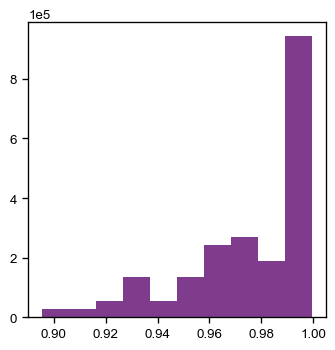

In [97]:
plt.hist(cases_unique / 19092)

In [98]:
(1 - 0.975) * 19092

477.3000000000004